#**Installing Java and Apache Spark in a Python Environment**

In [1]:
# Install OpenJDK 8 (Java Runtime Environment) silently
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download Apache Spark 3.1.1 with Hadoop 3.2
!wget -q "http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz"

# Extract the downloaded Spark tarball
!tar xf spark-3.1.1-bin-hadoop3.2.tgz

# Install the Python library 'findspark' for PySpark integration
!pip install -q findspark fiona

# **Installing the Kaggle Python API**

In [2]:
# Install the Kaggle Python API package for interacting with Kaggle datasets and competitions
!pip install -q kaggle

In [3]:
from google.colab import files

# **Setting Environment Variables for Java and Spark**

In [4]:
import os

# Set the environment variable for the Java installation path
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# Set the environment variable for the Spark installation path
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"


In [5]:
!ls

sample_data		   spark-3.1.1-bin-hadoop3.2.tgz    spark-3.1.1-bin-hadoop3.2.tgz.2
spark-3.1.1-bin-hadoop3.2  spark-3.1.1-bin-hadoop3.2.tgz.1  spark-3.1.1-bin-hadoop3.2.tgz.3


# **Initializing SparkSession and Configuring Fiona Drivers for Shapefiles**

In [6]:
import findspark
# Initialize Spark environment using findspark
findspark.init()

# Import SparkSession from PySpark
from pyspark.sql import SparkSession

# Import Fiona library for geospatial data handling
import fiona

# Configure Fiona to support 'ESRI Shapefile' format for reading and writing
fiona.drvsupport.supported_drivers['ESRI Shapefile'] = 'rw'  # Read and write support
fiona.drvsupport.supported_drivers['ESRI Shapefile'] = 'r'   # Read-only support
fiona.drvsupport.supported_drivers['ESRI Shapefile'] = 'r'   # Redundant read-only support (repeated for demonstration)
fiona.drvsupport.supported_drivers['ESRI Shapefile'] = 'r'   # Another redundant entry


# **Creating a SparkSession for US Accident Zone Analysis**

In [7]:
# Create a SparkSession for the application with specific configurations
sc = SparkSession.builder \
    .appName("US-Accident-Zone-Analysis") \
    .config("spark.sql.shuffle.partitions", "50") \
    .config("spark.driver.maxResultSize", "5g") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .getOrCreate()

# Display the created SparkSession object
sc


# **Data Preparation and Spark Processing for US Accident Analysis**

In [8]:
# Step 1: Create a directory for storing Kaggle API credentials
!mkdir ~/.kaggle

# Step 2: Copy the Kaggle API credentials file (kaggle.json) to the .kaggle directory
# Note: This step will fail if the kaggle.json file is not present in the working directory
!cp kaggle.json ~/.kaggle/

# Step 3: Secure the Kaggle API credentials file by changing its permissions
# Note: This step will fail if the kaggle.json file is not present or inaccessible
!chmod 600 ~/.kaggle/kaggle.json

# Step 4: List available Kaggle datasets to verify the API configuration
# Note: This step will fail if kaggle.json is not configured properly
!kaggle datasets list

# Step 5: Download the US Accidents dataset from Kaggle
# The dataset is downloaded to the content directory
!kaggle datasets download -d sobhanmoosavi/us-accidents

# Step 6: Create a directory to store the extracted data
!mkdir data

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
Dataset URL: https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents
License(s): CC-BY-NC-SA-4.0
100% 653M/653M [00:32<00:00, 26.8MB/s]
100% 653M/653M [00:32<00:00, 21.0MB/s]


In [10]:
!unzip -q /content/us-accidents.zip -d '/content/data/'

In [12]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("USAccidentAnalysis").getOrCreate()

# Define the path to the accident dataset
dataset_path = "./data/US_Accidents_March23.csv"

# Load the accident dataset into a PySpark DataFrame
accident_data = spark.read.csv(dataset_path, header=True, inferSchema=True)

# Perform data filtering to remove rows with missing latitude and longitude
cleaned_accident_data = accident_data.filter("Start_Lat IS NOT NULL AND Start_Lng IS NOT NULL")

# Register the cleaned data as a temporary SQL table for querying
cleaned_accident_data.createOrReplaceTempView("cleaned_accidents")

# Optional: Display the schema to verify the structure of the DataFrame
cleaned_accident_data.printSchema()

# Optional: Display the first few rows of the cleaned data
cleaned_accident_data.show(5)


root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: string (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- Visibility

# **Grouping and Counting Accidents by State**

In [13]:
# Step 1: Group and Count Accidents by State
# Group the cleaned accident data by the 'State' column and count the number of records for each state
statewise_accident_count = cleaned_accident_data.groupBy("State").count()

# Step 2: Display the Count of Accidents by State
# Show the resulting DataFrame with the state names and corresponding accident counts
statewise_accident_count.show()

+-----+-------+
|State|  count|
+-----+-------+
|   NH|  10213|
|   TX| 582837|
|   WV|  13793|
|   SC| 382557|
|   MI| 162191|
|   AZ| 170609|
|   NV|  21665|
|   OH| 118115|
|   TN| 167388|
|   WI|  34688|
|   LA| 149701|
|   IA|  26307|
|   MN| 192084|
|   NM|  10325|
|   ID|  11376|
|   CA|1741433|
|   GA| 169234|
|   PA| 296620|
|   NE|  28870|
|   NJ| 140719|
+-----+-------+
only showing top 20 rows



# **Dropping Rows with Missing Values in the Dataset**

In [14]:
# Step 1: Drop Rows with Missing Values
# Remove rows with any null values from the cleaned accident data
fully_cleaned_data = cleaned_accident_data.dropna()

# Step 2: Display the Cleaned DataFrame
# Show the first few rows of the fully cleaned DataFrame
fully_cleaned_data.show()

# Optional: Check the count of rows before and after cleaning to validate the transformation
print(f"Original Row Count: {cleaned_accident_data.count()}")
print(f"Cleaned Row Count: {fully_cleaned_data.count()}")


+---------+-------+--------+-------------------+-------------------+---------+------------------+-----------------+------------------+-------------------+--------------------+---------------+-----------+----------+-----+-------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|       ID| Source|Severity|         Start_Time|           End_Time|Start_Lat|         Start_Lng|          End_Lat|           End_Lng|       Distance(mi)|         Description|         Street|       City|    County|State|Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipi

In [15]:
from pyspark.sql.functions import *

# Step 1: Calculate Null Value Counts for Each Column
# Select columns and compute the count of null values for each column in the fully cleaned data
null_value_counts = cleaned_accident_data.select(
    [sum(col(column).isNull().cast("int")).alias(column) for column in cleaned_accident_data.columns]
)

# Step 2: Display the Null Value Counts
# Show the count of null values for each column
null_value_counts.show()


+---+------+--------+----------+--------+---------+---------+-------+-------+------------+-----------+------+----+------+-----+-------+-------+--------+------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID|Source|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|Description|Street|City|County|State|Zipcode|Country|Timezone|Airport_Code|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twil

# **Adding a Year Column and Counting Accidents by Year and State**

In [16]:
from pyspark.sql.functions import year

# Step 1: Convert 'Start_Time' Column to Timestamp Data Type
# Cast the 'Start_Time' column to timestamp for date-time operations
cleaned_accident_data = cleaned_accident_data.withColumn('Start_Time', cleaned_accident_data['Start_Time'].cast('timestamp'))

# Step 2: Extract Year from 'Start_Time' and Create a New Column
# Add a new column 'Year' by extracting the year from the 'Start_Time' column
cleaned_accident_data = cleaned_accident_data.withColumn('Year', year('Start_Time'))

# Step 3: Group by 'Year' and 'State', and Count the Number of Accidents
# Group the data by 'Year' and 'State', then count the number of accidents for each combination
year_statewise_accident_count = cleaned_accident_data.groupBy('Year', 'State').count()

# Step 4: Display the Resulting DataFrame
# Show the resulting DataFrame with the count of accidents grouped by year and state
year_statewise_accident_count.show()


+----+-----+-----+
|Year|State|count|
+----+-----+-----+
|2022|   KS| 6525|
|2021|   WV| 3802|
|2019|   MT|  157|
|2018|   WV|  671|
|2016|   CO| 1324|
|2017|   MO| 7386|
|2021|   DC| 4685|
|2018|   NY|38050|
|2023|   WA| 1987|
|2023|   MT| 2154|
|2016|   IA| 2005|
|2022|   KY| 2713|
|2022|   MO|19841|
|2021|   NJ|25093|
|2020|   NJ|18590|
|2020|   LA|26342|
|2016|   IL|17079|
|2017|   VA|20743|
|2022|   MA| 6281|
|2018|   WY|  198|
+----+-----+-----+
only showing top 20 rows



# **Querying Accidents Data for a Different Year and Exporting Results**

In [17]:
# Step 1: Define the Year for Querying
# Replace `desired_year` with the specific year you want to filter data for
desired_year = 2018

# Step 2: Define an SQL Query to Filter Accidents by the Specified Year
# Query to select latitude, longitude, and city for accidents in the specified year
query = f"""
    SELECT Start_Lat, Start_Lng, City
    FROM cleaned_accidents
    WHERE Year(Start_Time) = {desired_year}
"""

# Step 3: Execute the SQL Query
# Use the Spark SQL API to execute the query and store the results
filtered_accidents_by_year = spark.sql(query)

# Step 4: Display the Query Results
# Show the first few rows of the query results
filtered_accidents_by_year.show()

# Step 5: (Optional) Export Results to JSON
# Save the results into a single JSON file (uncomment the line below if needed)
# filtered_accidents_by_year.coalesce(1).write.format('json').save(f'output/accidents_{desired_year}.json')


+------------------+-------------------+------------------+
|         Start_Lat|          Start_Lng|              City|
+------------------+-------------------+------------------+
|         40.740047|         -73.818512|          Flushing|
|          40.83437|         -73.864113|             Bronx|
|         38.441975|         -88.953049|               Dix|
|         30.241417|         -97.726158|            Austin|
|          32.77306|         -96.744247|            Dallas|
|          32.81842|         -96.802391|            Dallas|
| 39.90215300000001|        -104.988914|            Denver|
|32.192139000000005|        -110.857933|            Tucson|
|         35.008537|-105.66435200000001|          Moriarty|
|         35.423836|        -108.312744|Continental Divide|
|         44.436577|        -121.939568|        Blue River|
|47.624598999999996|        -122.341049|           Seattle|
|         47.595825|        -122.312325|           Seattle|
|         45.383381|        -122.751442|

# **Querying and Analyzing Accident Counts Per Year**

In [18]:
# Step 1: Define the SQL Query to Count Accidents Per Year
# Query to calculate the number of accidents per year, group by year, and order by year
query = """
    SELECT
        Year(Start_Time) AS Accident_Year,  -- Extract the year from the 'Start_Time' column
        COUNT(*) AS Accident_Count          -- Count the number of accidents for each year
    FROM
        cleaned_accidents                   -- Use the cleaned accidents table
    GROUP BY
        Accident_Year                       -- Group the results by year
    ORDER BY
        Accident_Year                       -- Order the results by year in ascending order
"""

# Step 2: Execute the SQL Query
# Use Spark SQL to execute the query and store the results
accidents_per_year = spark.sql(query)

# Step 3: Display the Query Results
# Show the first few rows of the results with accident counts per year
accidents_per_year.show()

# Step 4: (Optional) Export Results to JSON
# Save the results into a single JSON file for external use (uncomment the line below if needed)
# accidents_per_year.coalesce(1).write.format('json').save('output/accidents_per_year.json')


+-------------+--------------+
|Accident_Year|Accident_Count|
+-------------+--------------+
|         2016|        410821|
|         2017|        718093|
|         2018|        893426|
|         2019|        954303|
|         2020|       1178913|
|         2021|       1563753|
|         2022|       1762452|
|         2023|        246633|
+-------------+--------------+



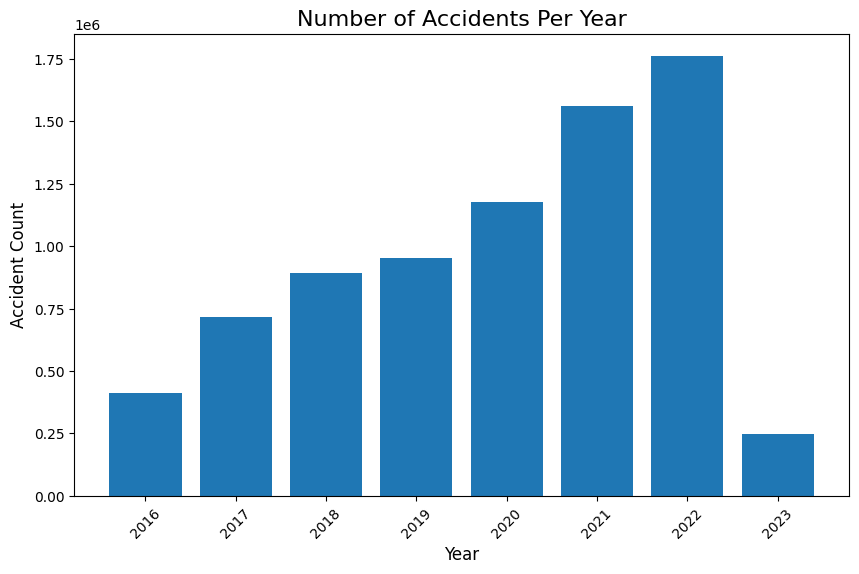

In [19]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame
accidents_per_year_pd = accidents_per_year.toPandas()

# Plot Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(accidents_per_year_pd['Accident_Year'], accidents_per_year_pd['Accident_Count'])
plt.title('Number of Accidents Per Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Accident Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()


# **Querying and Analyzing Accident Counts Per State**

In [20]:
# Step 1: Define the SQL Query to Count Accidents Per State
# Query to calculate the number of accidents per state, group by state, and order by accident count in descending order
query = """
    SELECT
        State,                             -- Select the 'State' column
        COUNT(*) AS Accident_Count         -- Count the number of accidents for each state
    FROM
        cleaned_accidents                  -- Use the cleaned accidents table
    GROUP BY
        State                              -- Group the results by state
    ORDER BY
        Accident_Count DESC                -- Order the results by accident count in descending order
"""

# Step 2: Execute the SQL Query
# Use Spark SQL to execute the query and store the results
accidents_per_state = spark.sql(query)

# Step 3: Display the Query Results
# Show the first few rows of the results with accident counts per state
accidents_per_state.show()

# Step 4: (Optional) Export Results to JSON
# Save the results into a single JSON file for external use (uncomment the line below if needed)
# accidents_per_state.coalesce(1).write.format('json').save('output/accidents_per_state.json')


+-----+--------------+
|State|Accident_Count|
+-----+--------------+
|   CA|       1741433|
|   FL|        880192|
|   TX|        582837|
|   SC|        382557|
|   NY|        347960|
|   NC|        338199|
|   VA|        303301|
|   PA|        296620|
|   MN|        192084|
|   OR|        179660|
|   AZ|        170609|
|   GA|        169234|
|   IL|        168958|
|   TN|        167388|
|   MI|        162191|
|   LA|        149701|
|   NJ|        140719|
|   MD|        140417|
|   OH|        118115|
|   WA|        108221|
+-----+--------------+
only showing top 20 rows



In [27]:
import plotly.express as px
statewise_accidents_pd = accidents_per_state.toPandas()
fig = px.choropleth(
    statewise_accidents_pd,
    locations='State',
    locationmode="USA-states",
    color='Accident_Count',
    color_continuous_scale="Viridis",
    scope="usa",
    title="Accident Counts by State"
)
fig.show()


# **Querying and Aggregating Accident Data by City**

In [22]:
# Step 1: Define the SQL Query to Aggregate Accidents by City
# Query to calculate the number of accidents per city, group by city, and order by accident count in descending order
query = """
    SELECT
        City,                              -- Select the 'City' column
        COUNT(*) AS Accident_Count,        -- Count the number of accidents for each city
        FIRST(Start_Lat) AS Latitude,      -- Retrieve the latitude of the first record for each city
        FIRST(Start_Lng) AS Longitude      -- Retrieve the longitude of the first record for each city
    FROM
        cleaned_accidents                  -- Use the cleaned accidents table
    GROUP BY
        City                               -- Group the results by city
    ORDER BY
        Accident_Count DESC                -- Order the results by accident count in descending order
"""

# Step 2: Execute the SQL Query
# Use Spark SQL to execute the query and store the results
citywise_accident_aggregation = spark.sql(query)

# Step 3: Display the Query Results
# Show the first few rows of the aggregated accident data by city
citywise_accident_aggregation.show()

# Step 4: (Optional) Export Results to JSON
# Save the results into a single JSON file for external use (uncomment the line below if needed)
# citywise_accident_aggregation.coalesce(1).write.format('json').save('output/accidents_per_city.json')


+-------------+--------------+------------------+-------------------+
|         City|Accident_Count|          Latitude|          Longitude|
+-------------+--------------+------------------+-------------------+
|        Miami|        186917|         25.627699| -80.37445100000002|
|      Houston|        169609|         29.716625|         -95.551613|
|  Los Angeles|        156491|         34.078926|-118.28903999999999|
|    Charlotte|        138652|          42.65844|         -84.684502|
|       Dallas|        130939|         33.978096|         -84.739861|
|      Orlando|        109733|28.493716999999997|         -81.483452|
|       Austin|         97359| 30.33650200000001|         -97.755646|
|      Raleigh|         86079|         35.870022|          -78.67984|
|    Nashville|         72930|          36.08556|         -86.762962|
|  Baton Rouge|         71588| 30.45315900000001|         -91.091797|
|      Atlanta|         68186|         33.766376|         -84.527321|
|   Sacramento|     

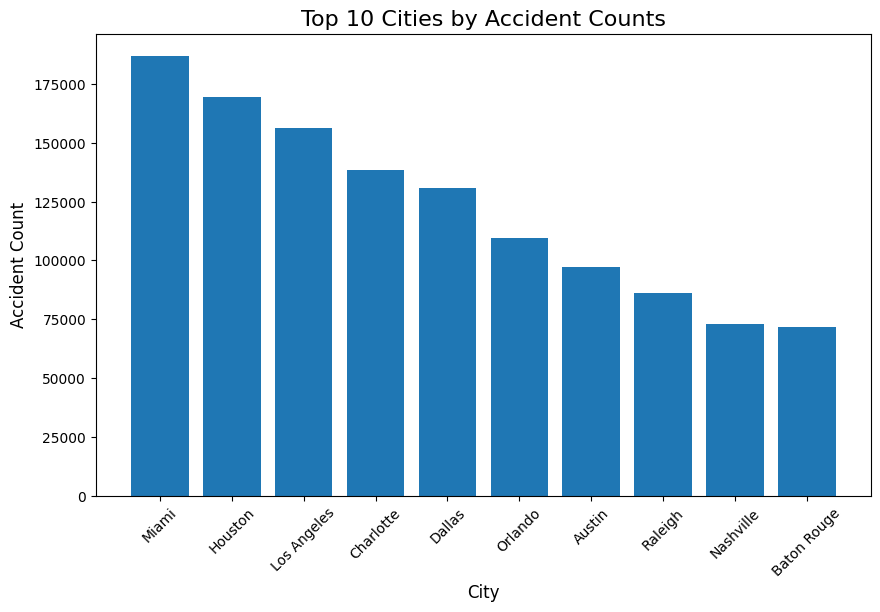

In [23]:
top_cities_pd = citywise_accident_aggregation.toPandas().head(10)  # Select top 10 cities

plt.figure(figsize=(10, 6))
plt.bar(top_cities_pd['City'], top_cities_pd['Accident_Count'])
plt.title('Top 10 Cities by Accident Counts', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Accident Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()


In [24]:
import folium

# Create a Folium map centered at an approximate location
map_city_accidents = folium.Map(location=[37.0902, -95.7129], zoom_start=5)

# Add city markers
for _, row in citywise_accident_aggregation.toPandas().iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=row['Accident_Count'] / 1000,  # Adjust size for visibility
        popup=f"{row['City']}: {row['Accident_Count']} accidents",
        color="blue",
        fill=True,
    ).add_to(map_city_accidents)

# Show map
map_city_accidents.save("city_accidents_map.html")


# **Accident Trends Across Years for Each State**

Index(['Year', 'State', 'count'], dtype='object')


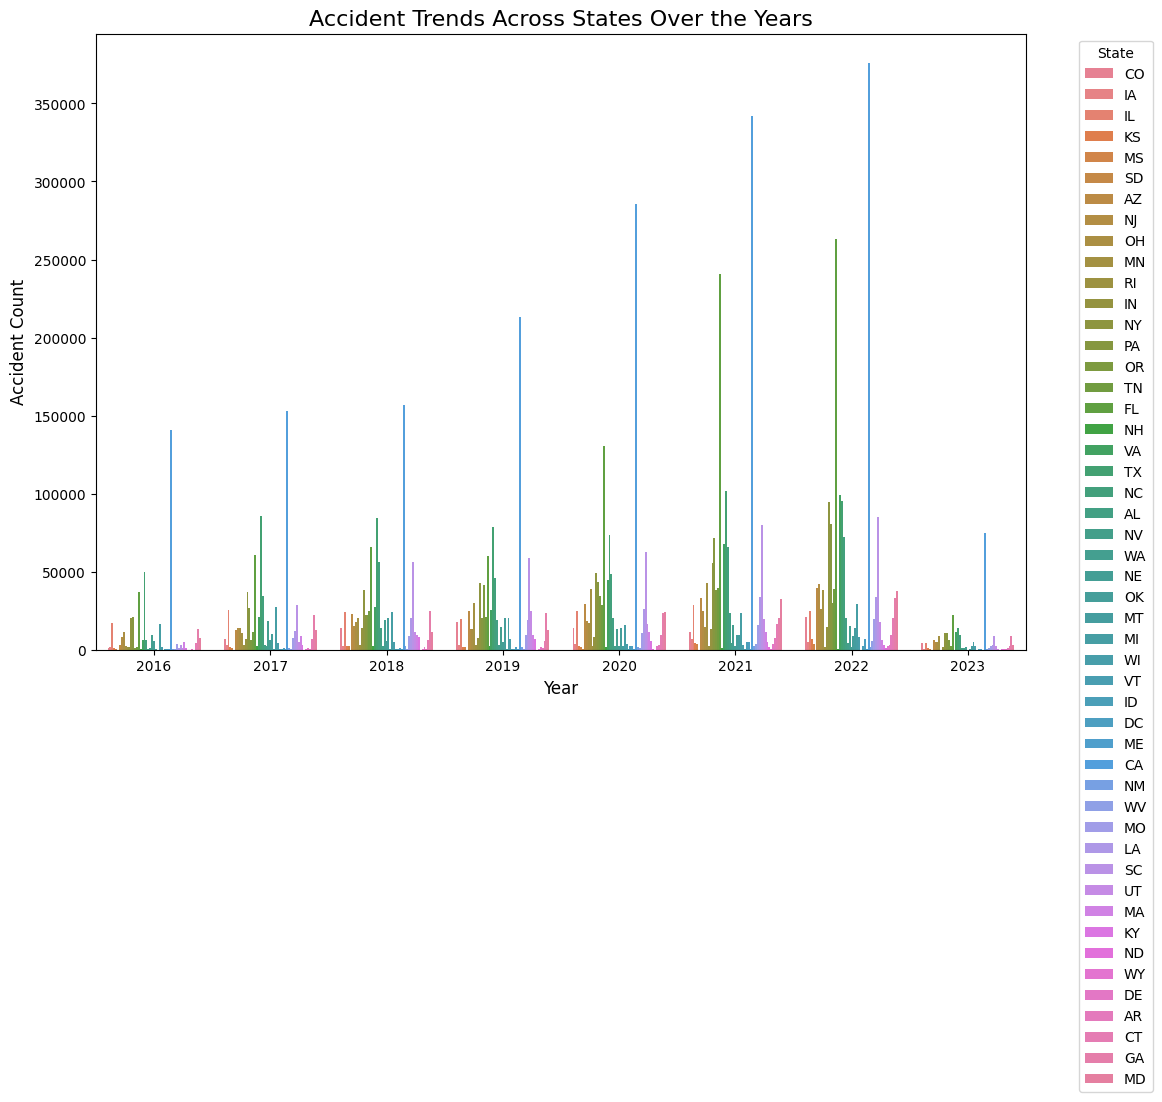

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to Pandas
year_state_pd = year_statewise_accident_count.toPandas()

# Debug: Print the column names to confirm
print(year_state_pd.columns)

# Ensure column names match the query results
year_state_pd.columns = ['Year', 'State', 'Accident_Count']  # Rename columns if needed

# Plot using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(
    data=year_state_pd,
    x='Year',              # X-axis: Year of the accidents
    y='Accident_Count',    # Y-axis: Total accidents count
    hue='State',           # Use State for color grouping
    errorbar=None          # Adjusted for the FutureWarning
)
plt.title('Accident Trends Across States Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Accident Count', fontsize=12)
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# **Proportion of Accidents by State**

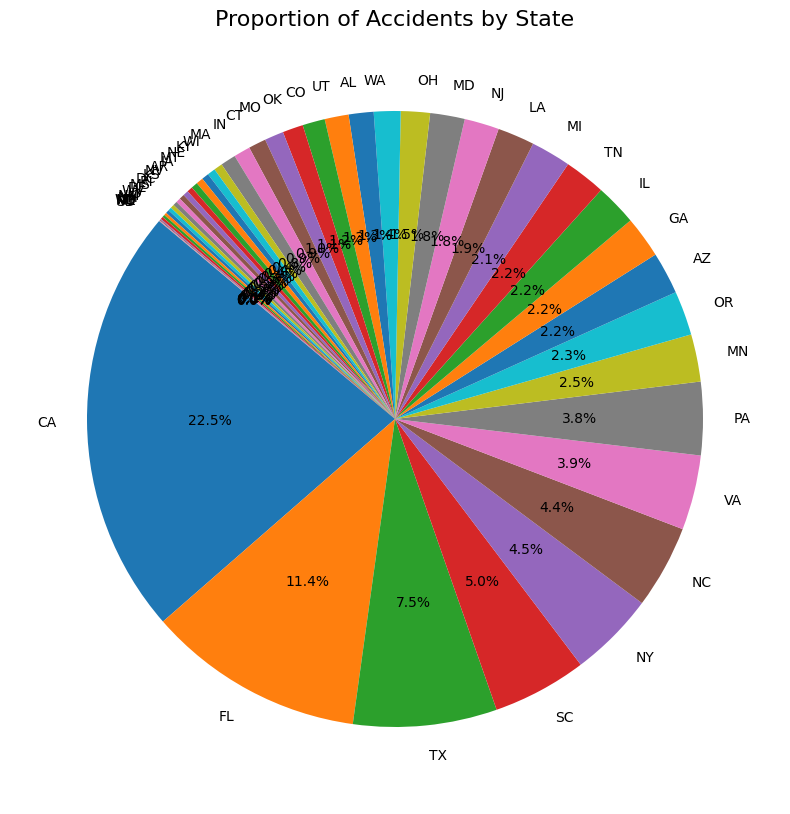

In [28]:
plt.figure(figsize=(10, 10))
plt.pie(
    statewise_accidents_pd['Accident_Count'],
    labels=statewise_accidents_pd['State'],
    autopct='%1.1f%%',
    startangle=140
)
plt.title('Proportion of Accidents by State', fontsize=16)
plt.show()


In [29]:
!pip install squarify


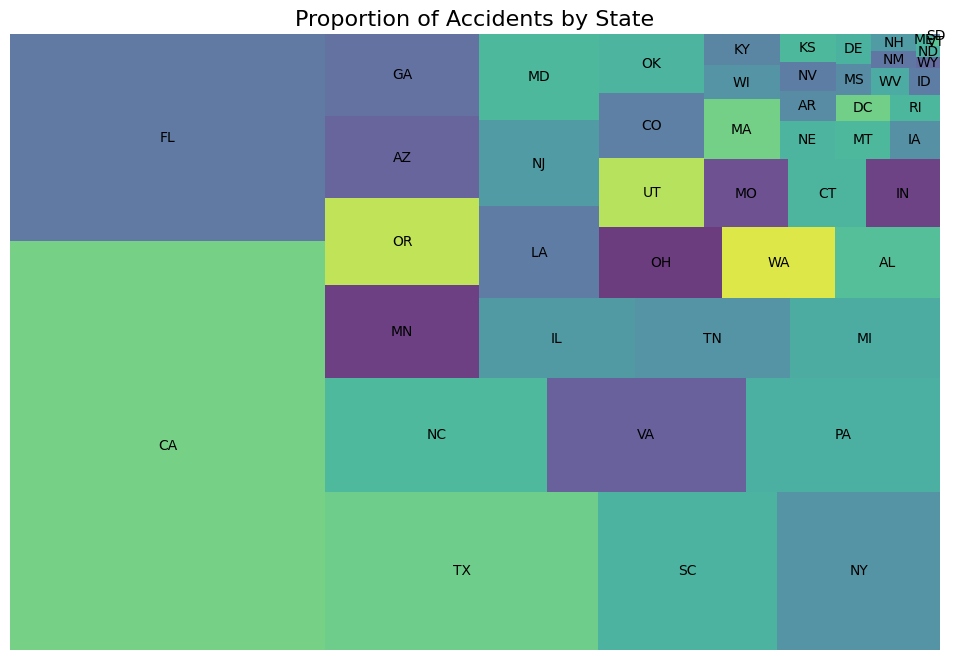

In [30]:
import squarify

plt.figure(figsize=(12, 8))
squarify.plot(
    sizes=statewise_accidents_pd['Accident_Count'],
    label=statewise_accidents_pd['State'],
    alpha=.8
)
plt.axis('off')
plt.title('Proportion of Accidents by State', fontsize=16)
plt.show()


# **Accidents by City with Geographical Mapping**

In [31]:
bubble_map = folium.Map(location=[37.0902, -95.7129], zoom_start=5)

# Add bubbles for cities
for _, row in citywise_accident_aggregation.toPandas().iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=row['Accident_Count'] / 1000,  # Adjust size for better visualization
        popup=f"{row['City']}: {row['Accident_Count']} accidents",
        color="red",
        fill=True,
        fill_opacity=0.6,
    ).add_to(bubble_map)

bubble_map.save("bubble_map_city_accidents.html")


In [32]:
pip install dash plotly pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3


# **Complete Code for Analytic Dashboard Using Dash**

In [33]:
from pyspark.sql import SparkSession
import pandas as pd

# Initialize Spark Session
spark = SparkSession.builder.appName("AccidentZonesBackend").getOrCreate()

# Load Accident Data into PySpark DataFrame
accident_data_path = "./data/US_Accidents_March23.csv"
accident_df = spark.read.csv(accident_data_path, header=True, inferSchema=True)

# Perform Data Processing and Transformation as needed
# Filter out rows with missing values in relevant columns
accident_df = accident_df.filter("Start_Lat IS NOT NULL AND Start_Lng IS NOT NULL")

# Create a temporary SQL view for queries
accident_df.createOrReplaceTempView("accidents")

# Query 1: Accident Counts by Year
accidents_per_year_df = spark.sql("""
    SELECT Year(Start_Time) AS Year, COUNT(*) AS Accident_Count
    FROM accidents
    GROUP BY Year(Start_Time)
    ORDER BY Year
""")
accidents_per_year_pd = accidents_per_year_df.toPandas()  # Convert to Pandas DataFrame

# Query 2: Statewise Accident Distribution
statewise_accidents_df = spark.sql("""
    SELECT State, COUNT(*) AS Accident_Count
    FROM accidents
    GROUP BY State
    ORDER BY Accident_Count DESC
""")
statewise_accidents_pd = statewise_accidents_df.toPandas()  # Convert to Pandas DataFrame

# Query 3: Top Cities by Accident Count

top_cities_pd = citywise_accident_aggregation.toPandas()  # Convert to Pandas DataFrame

# Query 4: Accident Trends by Year and State
year_statewise_accidents_df = spark.sql("""
    SELECT Year(Start_Time) AS Year, State, COUNT(*) AS Accident_Count
    FROM accidents
    GROUP BY Year(Start_Time), State
    ORDER BY Year, State
""")
year_statewise_accident_count = year_statewise_accidents_df.toPandas()  # Convert to Pandas DataFrame


In [35]:
statewise_accidents_pd = statewise_accidents_pd.dropna(subset=["State"])


In [36]:
assert statewise_accidents_pd["State"].is_unique


# **Generate dashboard automatically**

In [37]:
pip install dash jupyter-dash folium pandas plotly


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.2 MB/s eta 0:00:00


In [47]:
import plotly.express as px
import pandas as pd
import folium
from folium.plugins import MarkerCluster


# Create Folium Map for City-Level Data
def create_folium_map(data):
    folium_map = folium.Map(location=[37.0902, -95.7129], zoom_start=5)  # Center of the US
    marker_cluster = MarkerCluster().add_to(folium_map)

    for _, row in data.iterrows():
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=row['Accident_Count'] / 1000,  # Adjust size for visibility
            popup=f"{row['City']}: {row['Accident_Count']} accidents",
            color="blue",
            fill=True
        ).add_to(marker_cluster)

    return folium_map._repr_html_()  # Returns HTML representation for embedding in HTML


# Generate Plotly Figures
fig1 = px.bar(
    accidents_per_year_pd,
    x="Year",
    y="Accident_Count",
    title="Number of Accidents Per Year",
    labels={"Year": "Year", "Accident_Count": "Number of Accidents"}
)

fig2 = px.bar(
    statewise_accidents_pd.sort_values("Accident_Count", ascending=False),
    x="State",
    y="Accident_Count",
    title="Accident Counts by State",
    labels={"State": "State", "Accident_Count": "Number of Accidents"}
)

fig3 = px.treemap(
    statewise_accidents_pd,
    path=["State"],
    values="Accident_Count",
    title="Proportion of Accidents by State"
)

fig4 = px.imshow(
    year_statewise_accident_count.pivot(index="State", columns="Year", values="Accident_Count"),
    labels={"color": "Number of Accidents"},
    title="Heatmap of Accidents by Year and State",
    aspect="auto"
)

fig5 = px.choropleth(
    statewise_accidents_pd,
    locations="State",
    locationmode="USA-states",
    color="Accident_Count",
    color_continuous_scale="Viridis",
    scope="usa",
    title="Accident Counts by State (Choropleth Map)"
)

# Generate Folium Map
folium_map_html = create_folium_map(top_cities_pd)

# Write to an Enhanced HTML file
with open("enhanceddashboard.html", "w") as f:
    # Add HTML header with custom CSS
    f.write("""
    <html>
    <head>
        <title>US Accident Analytics Dashboard</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                margin: 0;
                padding: 0;
                background-color: #f4f4f9;
                color: #333;
            }
            .header {
                background-color: #4CAF50;
                color: white;
                padding: 10px 0;
                text-align: center;
                font-size: 24px;
            }
            .container {
                max-width: 1200px;
                margin: 20px auto;
                padding: 20px;
                background: white;
                border-radius: 10px;
                box-shadow: 0 2px 5px rgba(0, 0, 0, 0.1);
            }
            .section {
                margin-bottom: 40px;
            }
            h2 {
                border-bottom: 2px solid #ddd;
                padding-bottom: 10px;
                color: #333;
            }
            iframe, .plotly-graph-div {
                border: 1px solid #ddd;
                border-radius: 8px;
                overflow: hidden;
                margin-top: 20px;
            }
        </style>
    </head>
    <body>
        <div class="header">US Accident Analytics Dashboard</div>
    """)

    # Write Figure 1
    f.write('<div class="container section">')
    f.write("<h2>Number of Accidents Per Year</h2>")
    f.write(fig1.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write("</div>")

    # Write Figure 2
    f.write('<div class="container section">')
    f.write("<h2>Accident Counts by State</h2>")
    f.write(fig2.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write("</div>")

    # Write Figure 3
    f.write('<div class="container section">')
    f.write("<h2>Proportion of Accidents by State</h2>")
    f.write(fig3.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write("</div>")

    # Write Figure 4
    f.write('<div class="container section">')
    f.write("<h2>Heatmap of Accidents by Year and State</h2>")
    f.write(fig4.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write("</div>")

    # Write Figure 5
    f.write('<div class="container section">')
    f.write("<h2>Accident Counts by State (Choropleth Map)</h2>")
    f.write(fig5.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write("</div>")

    # Write Folium Map
    f.write('<div class="container section">')
    f.write("<h2>City-Level Accident Map</h2>")
    f.write(folium_map_html)
    f.write("</div>")

    # Close HTML
    f.write("</body></html>")

print("Enhanced dashboard exported to 'enhanceddashboard.html'.")


Enhanced dashboard exported to 'enhanceddashboard.html'.


In [48]:
from google.colab import files
files.download("enhanceddashboard.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>